# Валидация моделей

Рассмотри этапы валидации модели на примере задачи обнаружения вредоносных ссылок.

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import FunctionTransformer
# from sklearn.compose import make_column_transformer
from sklearn import set_config
set_config(display="diagram")

from scipy.stats  import norm, ttest_ind
from scipy import stats

# from xgboost import XGBClassifier

import shap

import warnings
warnings.simplefilter(action='ignore', category=(FutureWarning, UserWarning))

import matplotlib.pyplot as plt
import seaborn as sns

import boto3
import os
import awswrangler as wr
import matplotlib.pyplot as plt

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
data_file_name = "data_cleansed_2024-02-14 22:20:20.926766.parquet"

In [3]:
aws_key = os.environ['AWS_ACCESS_KEY']
aws_secret = os.environ['AWS_SECRET_ACCESS_KEY']
endpoint_url = os.environ['AWS_ENDPOINT_URL']
bucket_name = 'mlops-hw3-vos'
s3 = boto3.resource(
    's3',
    aws_access_key_id=aws_key,
    aws_secret_access_key=aws_secret,
    endpoint_url=endpoint_url,
)
bucket = s3.Bucket(bucket_name)
data_file_name = "data_cleansed_2024-02-14 22:20:20.926766.parquet"

In [4]:
path_ = f"s3://{bucket_name}/{data_file_name}"

In [5]:
df = pd.read_parquet(path_)

In [6]:
df.head(5)

,tranaction_id,tx_datetime,customer_id,terminal_id,tx_amount,tx_time_seconds,tx_time_days,tx_fraud,tx_fraud_scenario
0,1832792695,2022-11-04 15:12:51,58,190,13.42,101142771,1170,0,0
1,1832793055,2022-11-04 16:21:39,289,568,71.22,101146899,1170,0,0
2,1832793162,2022-11-04 13:01:13,356,996,77.00,101134873,1170,0,0
3,1832793237,2022-11-04 13:48:53,395,556,12.11,101137733,1170,0,0
4,1832793343,2022-11-04 22:14:53,463,324,1.47,101168093,1170,0,0


In [13]:
df['tx_fraud'].value_counts()

tx_fraud
0    44385601
1     1310572
Name: count, dtype: int64

In [9]:
len(df)

45696173

In [10]:
df_sample = df.sample(frac=0.1, random_state=1)

In [12]:
df_sample.head(4)

,tranaction_id,tx_datetime,customer_id,terminal_id,tx_amount,tx_time_seconds,tx_time_days,tx_fraud,tx_fraud_scenario
22863752,1838728250,2022-11-07 16:37:06,788311,243,27.42,101407026,1173,0,0
25522467,1854417744,2022-11-17 11:11:30,804178,657,63.34,102251490,1183,0,0
20305672,1867522623,2022-11-26 11:16:48,169685,973,32.70,103029408,1192,0,0
14187732,1845992984,2022-11-12 09:01:53,426326,224,31.63,101811713,1178,0,0


In [14]:
feature_cols = ["terminal_id", "tx_amount", "tx_time_seconds", "tx_time_days"]
target_col = "tx_fraud"

X = df_sample[feature_cols]
y = df_sample[target_col].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [15]:
rf_clf = RandomForestClassifier(
    n_estimators=35,
    max_depth=9,
    random_state=42,
    n_jobs=1,
)

pipe = Pipeline(steps=[
    ("classifier", rf_clf),
])
pipe

Pipeline(steps=[('classifier',
                 RandomForestClassifier(max_depth=9, n_estimators=35, n_jobs=1,
                                        random_state=42))])

In [16]:
from sklearn.metrics import roc_auc_score
pipe.fit(X_train, y_train);
y_pred = pipe.predict(X_test)

P, R, F1, _ = precision_recall_fscore_support(y_test, y_pred, average="binary")
roc_auc = roc_auc_score(y_test, y_pred)
print(f"P: {P:.2f}, R: {R:.2f}, F1: {F1:.5f}, AUC: {roc_auc:.5f}")

P: 1.00, R: 0.18, F1: 0.31155, AUC: 0.59226


## Упражнение 1

С помощью bootstrap постройте гистограмму распределения оценки $F_1$ на контрольной выборке.

Постройте теоретическое нормальное распределение на этой гистограмме.

Покажите среднее значение и стандартное отклонение.

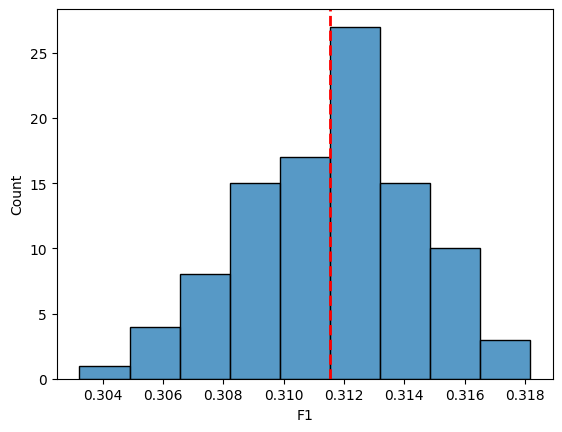

In [17]:
from sklearn.metrics import roc_auc_score
np.random.seed(42)

bootstrap_iterations = 100

df1 = pd.DataFrame(data={
    "y_test": y_test,
    "y_pred": y_pred,
})

scores = pd.DataFrame(data={
    "F1": 0.0, "P": 0.0, "R": 0.0, "AUC": 0.0
}, index=range(bootstrap_iterations))

for i in range(bootstrap_iterations):
    sample = df1.sample(frac=1.0, replace=True)
    scores.loc[i, "F1"] = f1_score(sample["y_test"], sample["y_pred"])
    scores.loc[i, "P"] = precision_score(sample["y_test"], sample["y_pred"])
    scores.loc[i, "R"] = recall_score(sample["y_test"], sample["y_pred"])
    scores.loc[i, "AUC"] = roc_auc_score(sample["y_test"], sample["y_pred"])

ax = sns.histplot(
    x=scores["F1"] 
)

ax.axvline(x=F1, color="red", linestyle="dashed", linewidth=2);

In [1]:
f1_mean = scores["F1"].mean()
f1_std = scores["F1"].std()


f1_low = f1_mean - 3 * f1_std
f1_upp = f1_mean + 3 * f1_std


ax = sns.histplot(
    x=scores["F1"] 
)

x = np.linspace(f1_low, f1_upp, 100)
y = norm.pdf(x, loc=f1_mean, scale=f1_std)
ax.plot(x, y, color="blue")
ax.axvline(f1_mean, color="red", linestyle='dashed')
ax.axvline(f1_mean-f1_std, color="green", linestyle='dashed')
ax.axvline(f1_mean+f1_std, color="green", linestyle='dashed');

plt.gcf()
plt.savefig("h1.png", transparent=True)

NameError: name 'scores' is not defined

<Figure size 640x480 with 0 Axes>

## Подбор гипрепараметров

In [19]:
params_grid = {
    "classifier__n_estimators": range(50, 70, 10),
    "classifier__max_depth": range(15, 20),
}

random_search_res = RandomizedSearchCV(
    pipe,
    params_grid,
    n_iter=100,
    cv=5,
    scoring="f1",
    n_jobs=-1,
    verbose=1,
    refit=True,
    random_state=42,
).fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [ ]:
random_search_res.best_params_

In [21]:
y_pred_candidate = random_search_res.predict(X_test)
P_candidate, R_candidate, F1_candidate, _ = precision_recall_fscore_support(y_test, y_pred_candidate, average="binary")
print(f"P_candidate: {P_candidate:.2f}, R_candidate: {R_candidate:.2f}, F1_candidate: {F1_candidate:.5f}")

P_candidate: 1.00, R_candidate: 0.61, F1_candidate: 0.75892


## Упражнение 2

1. Постройте с помощью booststrap выборку оценки $F_1$ для лучшей модели после подбора гиперпарамтеров.
2. Сравните с помощью t-теста базовую модель и кандидата. Примите $\alpha = 0.01$
3. Попробуйте расширить пространство гипрепараметров, чтобы поиск выдал лучший результат


$$n = \frac{2(Z_{\alpha / 2} + Z_{\beta})^2 \sigma^2}{\delta^2}$$

$Z_{\alpha / 2}$ - критическое значение, соответствующее искомому уровню значимости $\alpha / 2$. Берется $\alpha / 2$ потому, что мы рассматриваем двусторонний тест. Значение $\alpha$ определяет уровень допустимости ошибки первого рода. Как правило $\alpha$ берется 0.05 для обычных исследовний и 0.01 для случая медицинских исследований или иных, где ошибка первого рода (отвергнута верная нулевая гипотеза) является критически важной.

$Z_\beta$ - критическое значение, соотвествующее заданному уровню статистической мощности. Значение $\beta$ определяет вероятность ошибки второго рода (принята неверная нулевая гипотеза). Как правило $\beta$ устанавливается на уровне 0.8 или 0.9.

$\sigma$ - стандартное отклонение

$\delta$ - размер эффекта, который необходимо выловить

In [27]:
from sklearn.metrics import roc_auc_score
df_cand = pd.DataFrame(data={
    "y_test": y_test,
    "y_pred": y_pred_candidate,
})

scores_cand = pd.DataFrame(data={
    "F1": 0.0, "P": 0.0, "R": 0.0, "AUC": 0.0
}, index=range(bootstrap_iterations))

for i in range(bootstrap_iterations):
    sample = df_cand.sample(frac=1.0, replace=True)
    scores_cand.loc[i, "F1"] = f1_score(sample["y_test"], sample["y_pred"])
    scores_cand.loc[i, "P"] = precision_score(sample["y_test"], sample["y_pred"])
    scores_cand.loc[i, "R"] = recall_score(sample["y_test"], sample["y_pred"])
    scores_cand.loc[i, "AUC"] = roc_auc_score(sample["y_test"], sample["y_pred"])

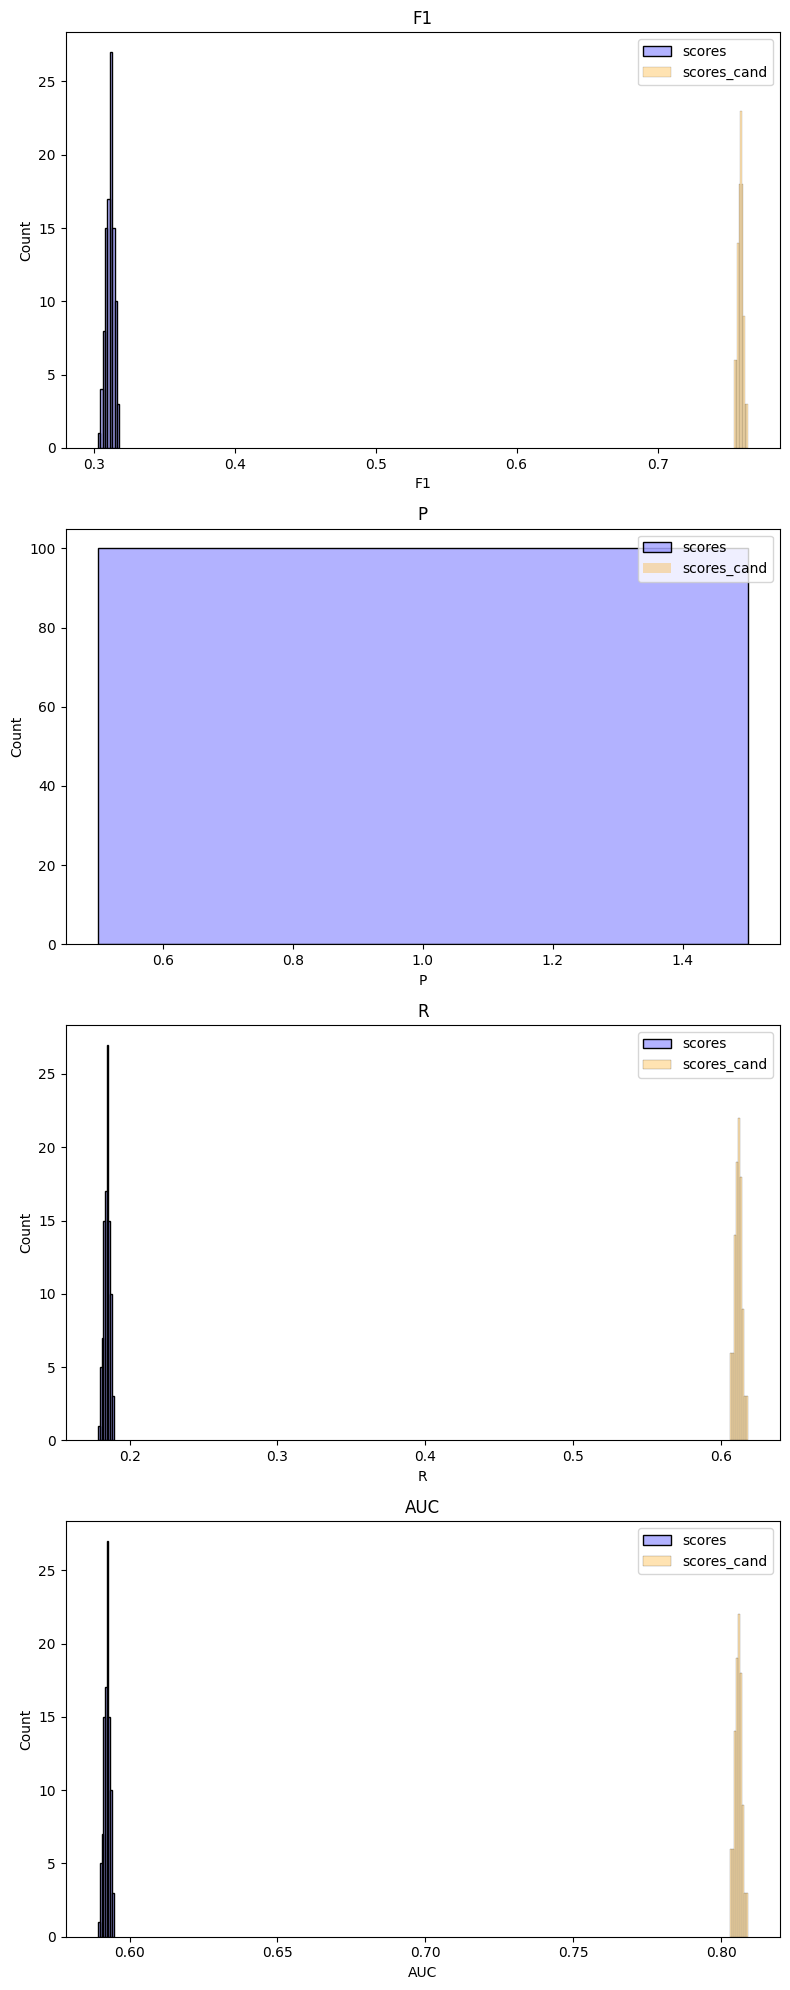

In [29]:
# Loop through the columns
columns_to_plot = ['F1', 'P', 'R', 'AUC']

# Create a figure and axis for the plot
fig, axes = plt.subplots(len(columns_to_plot), 1, figsize=(8, 5*len(columns_to_plot)))


for i, column in enumerate(columns_to_plot):
    # Plot histograms for each dataset
    sns.histplot(data=scores, x=column, ax=axes[i], color='blue', label='scores', alpha=0.3)
    sns.histplot(data=scores_cand, x=column, ax=axes[i], color='orange', label='scores_cand', alpha=0.3)

    # Set plot labels and titles
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Count')
    axes[i].set_title(f'{column}')

    # Add legend
    axes[i].legend()

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

In [30]:
alpha = 0.01

for name in ['F1', 'P']:
    # p-value for F1 score
    pvalue = ttest_ind(scores[name], scores_cand[name]).pvalue

    print(f"p-value ({name}): {pvalue:g}\t-\t", end='')
    if pvalue < alpha:
        print("Reject null hypothesis.")
    else:
        print("Accept null hypothesis.")


p-value (F1): 0	-	Reject null hypothesis.
p-value (P): 7.26712e-19	-	Reject null hypothesis.


Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.


In [31]:
import numpy as np
mean = scores['P'].mean()
std_error = scores['P'].std() / np.sqrt(len(scores['P']))
confidence_level = 0.95

confidence_interval = stats.t.interval(confidence_level, len(scores)-1, mean, std_error)
print(f'Confidence interval for precision: {confidence_interval[0]:.4f} <- {scores["P"].mean():.4f} -> {confidence_interval[1]:.4f}')


Confidence interval for precision: nan <- 1.0000 -> nan


invalid value encountered in multiply
invalid value encountered in multiply


## Интерпретация предсказаний

Рассмотрим результат анализа с помощью SHAP

In [ ]:
df[(df["y_test"] == 1) & (df["y_pred"] == 0)].head()

In [ ]:
explainer = shap.TreeExplainer(
    pipe.named_steps["classifier"],
    feature_names=url_vectorizer.get_feature_names_out(),
)

test_object = X_test.iloc[10]
print(test_object)
test_object_vect = url_vectorizer.transform([test_object]).toarray()
shap_values = explainer.shap_values(test_object_vect)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], test_object_vect, feature_names=url_vectorizer.get_feature_names_out())

## Упражнение 3.

Проведите с помощью SHAP анализ ошибок модели обоих типов и дайте предложения по улучшению модели.